In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from copy import deepcopy
import math
import matplotlib.pyplot as plt
import numpy as np
import pydrake
import os
import sys
import time
from torchviz import make_dot

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.probabilistic_scene_grammar_nodes import *
from scene_generation.models.probabilistic_scene_grammar_model import *

In [2]:
seed = 47
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.set_default_tensor_type(torch.DoubleTensor)
pyro.enable_validation(True)
pyro.clear_param_store()

/home/gizatt/projects/scene_generation/models/probabilistic_scene_grammar_nodes.py:192: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.production_dist.log_prob(torch.tensor(selected_rules)).sum()


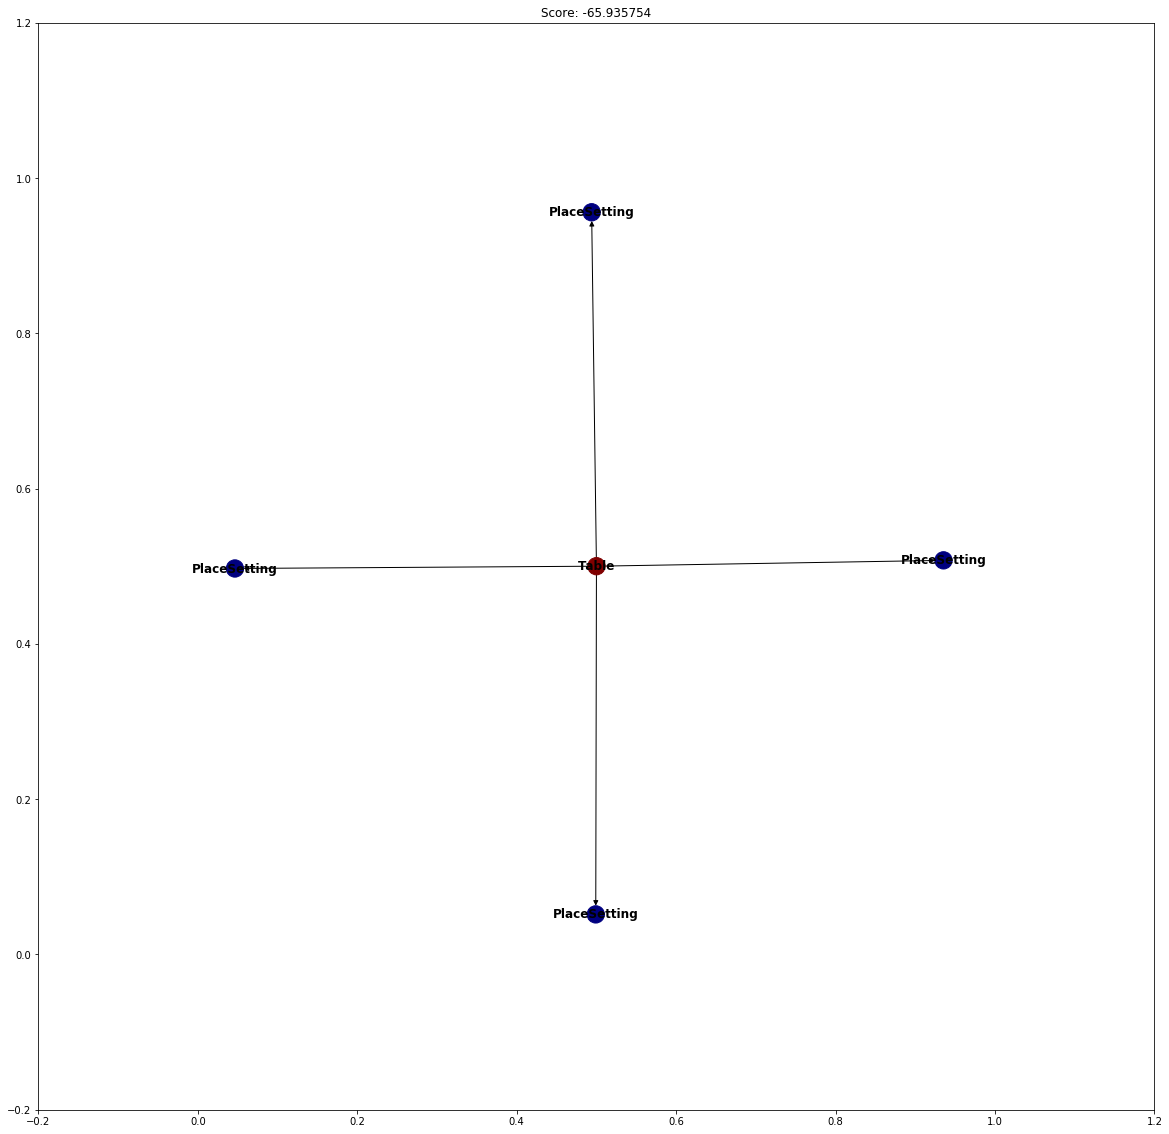

In [3]:
plt.figure().set_size_inches(20, 20)
hyper_parse_tree = generate_hyperexpanded_parse_tree()
draw_parse_tree(hyper_parse_tree, label_name=True, label_score=False)

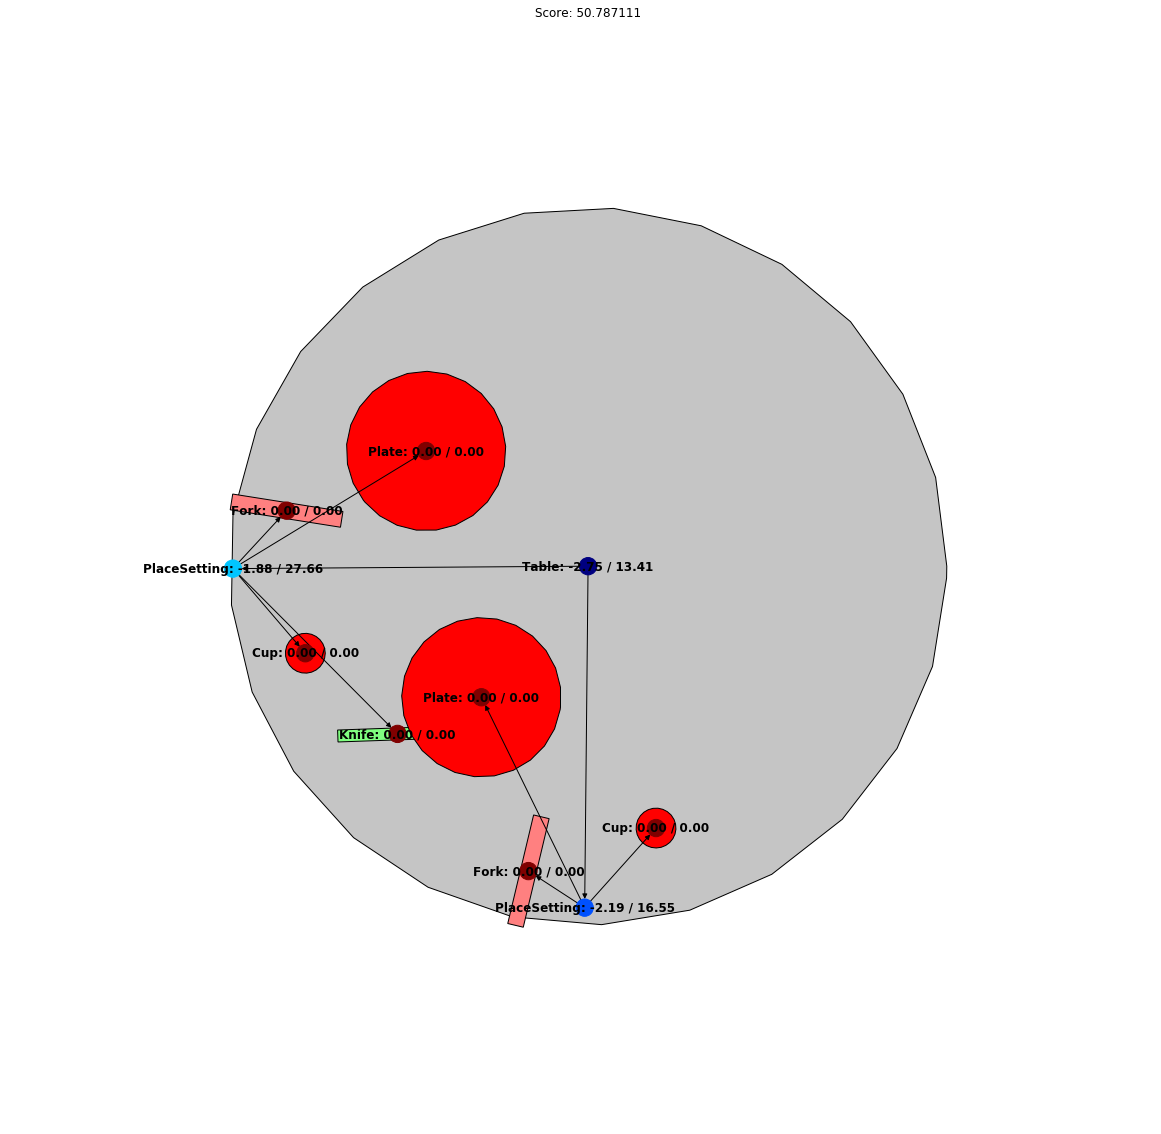

In [17]:
# Generate a ground truth test environment
plt.figure().set_size_inches(20, 20)
trace = poutine.trace(generate_unconditioned_parse_tree).get_trace()
parse_tree = trace.nodes["_RETURN"]["value"]        
score = trace.log_prob_sum()
yaml_env = convert_tree_to_yaml_env(parse_tree)
DrawYamlEnvironmentPlanar(yaml_env, base_environment_type="table_setting", ax=plt.gca())
draw_parse_tree(parse_tree, label_name=True, label_score=True)

In [5]:
# Clear gradients
for param_name in pyro.get_param_store():
    pyro.param(param_name).grad = None
# Calc gradients of score w.r.t. all params
trace = poutine.trace(rerun_conditioned_parse_tree).get_trace(
    parse_tree, score_terminal_products=True, score_nonterminal_products=True)
score = trace.log_prob_sum()
print("score: ", score)
score.backward(retain_graph=True)
def print_param_store(grads=False):
    for param_name in pyro.get_param_store().keys():
        val = pyro.param(param_name)#.tolist()
        grad = pyro.param(param_name).grad
        #if isinstance(val, float):
        #    val = [val]
        if grads:
            print(param_name, ": ", val.data, ", unconstrained grad: ", pyro.get_param_store()._params[param_name].grad)
        else:
            print(param_name, ": ", val.data)
print_param_store(grads=True)
fork_node = next(obj for obj in parse_tree.nodes if isinstance(obj, Fork))
#print(list(parse_tree.predecessors(fork_node))[0].offset_dist.scale)

score:  tensor(71.3624, grad_fn=<AddBackward0>)
place_setting_left_knife_var :  tensor([0.0100, 0.0100, 0.0100]) , unconstrained grad:  None
place_setting_left_fork_mean :  tensor([-0.1500,  0.1600,  0.0000]) , unconstrained grad:  tensor([ 5.6743, 88.3264, 13.3529])
place_setting_right_spoon_mean :  tensor([0.1500, 0.1600, 0.0000]) , unconstrained grad:  None
place_setting_right_spoon_var :  tensor([0.0100, 0.0100, 0.0100]) , unconstrained grad:  None
place_setting_plate_var :  tensor([0.0100, 0.0100, 3.0000]) , unconstrained grad:  tensor([-1.6609,  0.6712, -0.6737])
place_setting_left_spoon_var :  tensor([0.0100, 0.0100, 0.0100]) , unconstrained grad:  None
place_setting_plate_mean :  tensor([0.0000, 0.1600, 0.0000]) , unconstrained grad:  tensor([-80.5042, -55.4825,   0.6406])
place_setting_right_knife_mean :  tensor([0.1500, 0.1600, 0.0000]) , unconstrained grad:  tensor([104.6682, -52.5552,  25.8204])
place_setting_right_fork_var :  tensor([0.0100, 0.0100, 0.0100]) , unconstraine

In [6]:
fork = next(obj for obj in parse_tree.nodes if isinstance(obj, Fork))
fork_prod = list(parse_tree.predecessors(fork))[0]
loc = pyro.param("place_setting_left_fork_mean") # fork_prod.offset_dist.mean
scale = pyro.param("place_setting_left_fork_var") # fork_prod.offset_dist.variance
loc.grad = None
scale.grad = None

local_score = fork_prod.score_products(list(parse_tree.predecessors(fork_prod))[0], [fork])
local_score.backward(retain_graph=True)
print(local_score)
print("Loc: ", loc, loc.grad)
print("Scale: ", scale, scale.grad)

tensor(9.1166, grad_fn=<SumBackward2>)
Loc:  tensor([-0.1500,  0.1600,  0.0000], requires_grad=True) tensor([  -0.3696, -117.9327,  157.9026])
Scale:  tensor([0.0100, 0.0100, 0.0100], grad_fn=<AddBackward0>) None


In [ ]:
score = poutine.trace()

In [ ]:
import yaml
import multiprocessing
from functools import partial

with open("../models/table_setting_environments_generated.yaml") as f:
    envs = yaml.load(f)
    envs = [envs[k] for k in envs.keys()]

all_observed_trees = []
for env in envs:
    tree, score = guess_parse_tree_from_yaml(
        env, outer_iterations=10,
        num_attempts=3, verbose=False)
    print("Tree with score %f" % score)
    all_observed_trees.append(tree)

In [ ]:
from matplotlib.patches import Ellipse

# Get offsets of each object class from each place setting
offsets_by_class = {}
scores_by_class = {}
gt_by_class = {}
for observed_tree in all_observed_trees:
    score, _ = score_tree(observed_tree)
    for node in observed_tree.nodes:
        if isinstance(node, PlaceSetting.ObjectProductionRule):
            child_class = node.object_name
            if child_class not in offsets_by_class.keys():
                offsets_by_class[child_class] = []
                gt_by_class[child_class] = node.offset_dist
                scores_by_class[child_class] = []
            parent = get_node_parent_or_none(observed_tree, node)
            assert(parent)
            child = list(observed_tree.successors(node))[0]
            offsets_by_class[child_class].append(
                node._recover_rel_pose_from_abs_pose(parent, child.pose).detach().numpy().copy())
            scores_by_class[child_class].append(score.item())
                                                     
plt.figure()
n_classes = len(offsets_by_class.keys())
for k, class_name in enumerate(offsets_by_class.keys()):
    plt.subplot(1, n_classes, k+1)
    plt.title(class_name)
    pts = np.vstack(offsets_by_class[class_name]).T
    plt.scatter(pts[0, :], pts[1, :], c=scores_by_class[class_name], alpha=0.25)
    
    gt_mean = gt_by_class[class_name].mean.detach().numpy().copy()
    gt_std = np.sqrt(gt_by_class[class_name].variance.detach().numpy().copy())
    ell = Ellipse(xy=gt_mean[:2],
                  width=gt_std[0]*3, height=gt_std[1]*3)
    ell.set_color('red')
    ell.set_facecolor('none')
    print(gt_mean, gt_std)
    plt.gca().add_artist(ell)
    plt.xlim(gt_mean[0]-0.2, gt_mean[0]+0.2)
    plt.ylim(gt_mean[1]-0.2, gt_mean[1]+0.2)
    
    
print(scores_by_class)
plt.tight_layout()

In [ ]:
draw_parse_tree(all_observed_trees[2], label_name=True, label_score=True)

In [12]:
# Perturb params
for name in pyro.get_param_store().get_all_param_names():
    data = pyro.get_param_store()._params[name].data
    data += dist.Normal(torch.zeros(data.shape), torch.ones(data.shape)*0.1).sample()

In [ ]:
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import yaml

with open("../models/table_setting_environments_generated.yaml") as f:
    envs = yaml.load(f)
    envs = [envs[k] for k in envs.keys()]


# setup the optimizer
adam_params = {"lr": 0.1, "betas": (0.8, 0.95)}
optimizer = Adam(adam_params)


param_val_history = []
score_history = []

# do gradient steps
print_param_store()
if len(score_history) > 0:
    best_loss_yet = min(score_history)
else:
    best_loss_yet = np.infty
for step in range(300):
    # Pick a few random environment and parse them
    losses = []
    active_param_names = set()
    for p_k in range(5):
        env = random.choice(envs)
        observed_tree, score = guess_parse_tree_from_yaml(env, outer_iterations=1, num_attempts=2)
        print("Obs tree with score %f" % score)
        losses.append(-1. * score)
        active_param_names = set().union(active_param_names,
            *[node.get_param_names() for node in observed_tree.nodes])
    # TODO(Gizatt) Use logsumexp for the sum here instead of regular sum.
    # (They're log-probs, not regular probs, so shouldn't be added straight-up.)
    # (Due to monotonicity it's probably OK anyway, but for correctness...)
    loss = torch.stack(losses).mean()
    #active_param_names = ["place_setting_left_fork_mean"]
    params = set(pyro.get_param_store()._params[name] for name in active_param_names)
    pyro.infer.util.zero_grads(params)
    loss.backward(retain_graph=True)
    optimizer(params)
    # zero gradients
    pyro.infer.util.zero_grads(params)
    loss = pyro.infer.util.torch_item(loss)
    #loss = svi.step(observed_tree)
    score_history.append(loss)
    if loss < best_loss_yet:
        best_loss_yet = loss
        pyro.get_param_store().save("best_on_test_save.pyro")

    all_param_state = {name: pyro.param(name).detach().cpu().numpy().copy() for name in active_param_names}
    param_val_history.append(all_param_state)
    print("Loss: ", loss)
    print("Place setting plate mean: ", pyro.param("place_setting_plate_mean"))
    print("Place setting plate var: ", pyro.param("place_setting_plate_var"))
print("Final loss: ", loss)
print_param_store()

place_setting_left_knife_var :  tensor([0.0096, 0.0106, 0.0102])
place_setting_left_fork_mean :  tensor([-0.0756,  0.0592, -0.0740])
place_setting_right_spoon_mean :  tensor([0.1180, 0.0969, 0.0073])
place_setting_right_spoon_var :  tensor([0.0105, 0.0105, 0.0095])
place_setting_plate_var :  tensor([0.0102, 0.0102, 3.1661])
place_setting_left_spoon_var :  tensor([0.0104, 0.0106, 0.0103])
place_setting_plate_mean :  tensor([-0.1697,  0.2338, -0.1463])
place_setting_right_knife_mean :  tensor([0.2034, 0.2157, 0.1226])
place_setting_right_fork_var :  tensor([0.0101, 0.0101, 0.0105])
place_setting_left_spoon_mean :  tensor([-0.2855,  0.1083,  0.1558])
table_independent_set_production_probs :  tensor([0.5201, 0.5038, 0.5140, 0.5198])
place_setting_production_weights :  tensor([7.1463e-11, 5.2680e-11, 6.7014e-02, 5.7867e-11, 6.4573e-11, 6.1055e-11,
        1.1235e-01, 5.5221e-11, 5.7148e-11, 6.0303e-11, 6.8002e-11, 7.1382e-11,
        6.5092e-11, 6.4060e-11, 5.9720e-11, 6.8125e-11, 3.1818e-0

Obs tree with score 26.251057
Obs tree with score 12.246706
Obs tree with score 37.448548
Obs tree with score -2.828839
Obs tree with score -20.407882
Loss:  -10.5419179499
Place setting plate mean:  tensor([-0.0130,  0.1498,  0.7934], requires_grad=True)
Place setting plate var:  tensor([0.0165, 0.0178, 3.0439], grad_fn=<AddBackward0>)
Obs tree with score 59.707257
Obs tree with score 4.838397
Obs tree with score -79.158024
Obs tree with score 41.473059
Obs tree with score 20.535110
Loss:  -9.47915965202
Place setting plate mean:  tensor([-0.0070,  0.1449,  0.7826], requires_grad=True)
Place setting plate var:  tensor([0.0167, 0.0181, 2.9797], grad_fn=<AddBackward0>)
Obs tree with score 4.025182
Obs tree with score 10.626833
Obs tree with score 16.732431
Obs tree with score -3.007618
Obs tree with score 18.647461
Loss:  -9.40485779808
Place setting plate mean:  tensor([-6.6317e-04,  1.4319e-01,  7.5416e-01], requires_grad=True)
Place setting plate var:  tensor([0.0168, 0.0184, 2.8889]

Obs tree with score 90.260551
Loss:  -33.3364152005
Place setting plate mean:  tensor([ 0.0009,  0.1575, -0.6660], requires_grad=True)
Place setting plate var:  tensor([0.0172, 0.0191, 3.1747], grad_fn=<AddBackward0>)
Obs tree with score 36.587453
Obs tree with score 2.231207
Obs tree with score 32.020364
Obs tree with score 22.199410
Obs tree with score 24.887564
Loss:  -23.585199532
Place setting plate mean:  tensor([ 0.0109,  0.1650, -0.6336], requires_grad=True)
Place setting plate var:  tensor([0.0171, 0.0191, 3.1033], grad_fn=<AddBackward0>)
Obs tree with score 20.963303
Obs tree with score 45.663495
Obs tree with score 22.128318
Obs tree with score 56.629893
Obs tree with score 78.156758
Loss:  -44.7083531861
Place setting plate mean:  tensor([ 0.0155,  0.1648, -0.6036], requires_grad=True)
Place setting plate var:  tensor([0.0171, 0.0190, 3.0139], grad_fn=<AddBackward0>)
Obs tree with score -4.497457
Obs tree with score 12.114367
Obs tree with score 45.025885
Obs tree with scor

Obs tree with score 12.470992
Obs tree with score 21.429883
Obs tree with score 24.424531
Obs tree with score 39.407846
Obs tree with score 63.966582
Loss:  -32.3399667519
Place setting plate mean:  tensor([ 0.0039,  0.1439, -0.0723], requires_grad=True)
Place setting plate var:  tensor([0.0164, 0.0159, 3.5343], grad_fn=<AddBackward0>)
Obs tree with score 34.291345
Obs tree with score 33.264782
Obs tree with score 49.619347
Obs tree with score 24.523074
Obs tree with score 20.560174
Loss:  -32.4517444651
Place setting plate mean:  tensor([ 0.0031,  0.1315, -0.0398], requires_grad=True)
Place setting plate var:  tensor([0.0163, 0.0157, 3.4290], grad_fn=<AddBackward0>)
Obs tree with score 55.394202
Obs tree with score 11.419974
Obs tree with score 17.247247
Obs tree with score 51.357983
Obs tree with score 34.245572
Loss:  -33.9329955784
Place setting plate mean:  tensor([0.0048, 0.1469, 0.0049], requires_grad=True)
Place setting plate var:  tensor([0.0162, 0.0156, 3.3905], grad_fn=<AddB

Obs tree with score -4.185778
Loss:  -16.6899587039
Place setting plate mean:  tensor([-0.0042,  0.1573, -0.2587], requires_grad=True)
Place setting plate var:  tensor([0.0152, 0.0142, 2.9038], grad_fn=<AddBackward0>)
Obs tree with score 17.304814
Obs tree with score -4.121378
Obs tree with score 33.037426
Obs tree with score 40.255403
Obs tree with score 9.537393
Loss:  -19.2027315645
Place setting plate mean:  tensor([ 0.0112,  0.1502, -0.2216], requires_grad=True)
Place setting plate var:  tensor([0.0152, 0.0141, 2.8566], grad_fn=<AddBackward0>)
Obs tree with score 43.853050
Obs tree with score 59.890634
Obs tree with score 45.070180
Obs tree with score 64.079330
Obs tree with score 15.978132
Loss:  -45.7742652568
Place setting plate mean:  tensor([ 0.0032,  0.1486, -0.1762], requires_grad=True)
Place setting plate var:  tensor([0.0152, 0.0139, 2.9701], grad_fn=<AddBackward0>)
Obs tree with score 23.800763
Obs tree with score 65.869829
Obs tree with score 37.617891
Obs tree with sco

['place_setting_left_knife_var', 'place_setting_left_fork_mean', 'place_setting_right_spoon_mean', 'place_setting_right_spoon_var', 'place_setting_plate_var', 'place_setting_left_spoon_var', 'place_setting_plate_mean', 'place_setting_right_knife_mean', 'place_setting_right_fork_var', 'place_setting_left_spoon_mean', 'table_independent_set_production_probs', 'place_setting_production_weights', 'place_setting_right_knife_var', 'place_setting_cup_var', 'place_setting_left_fork_var', 'place_setting_left_knife_mean', 'place_setting_right_fork_mean', 'place_setting_cup_mean']
(3, 500)
(3, 500)
(3, 2)
(3, 2)
(4, 500)


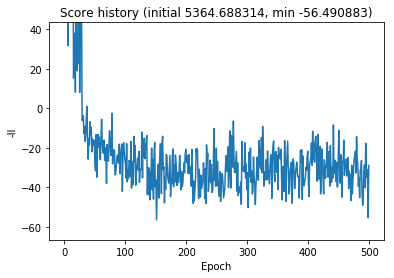

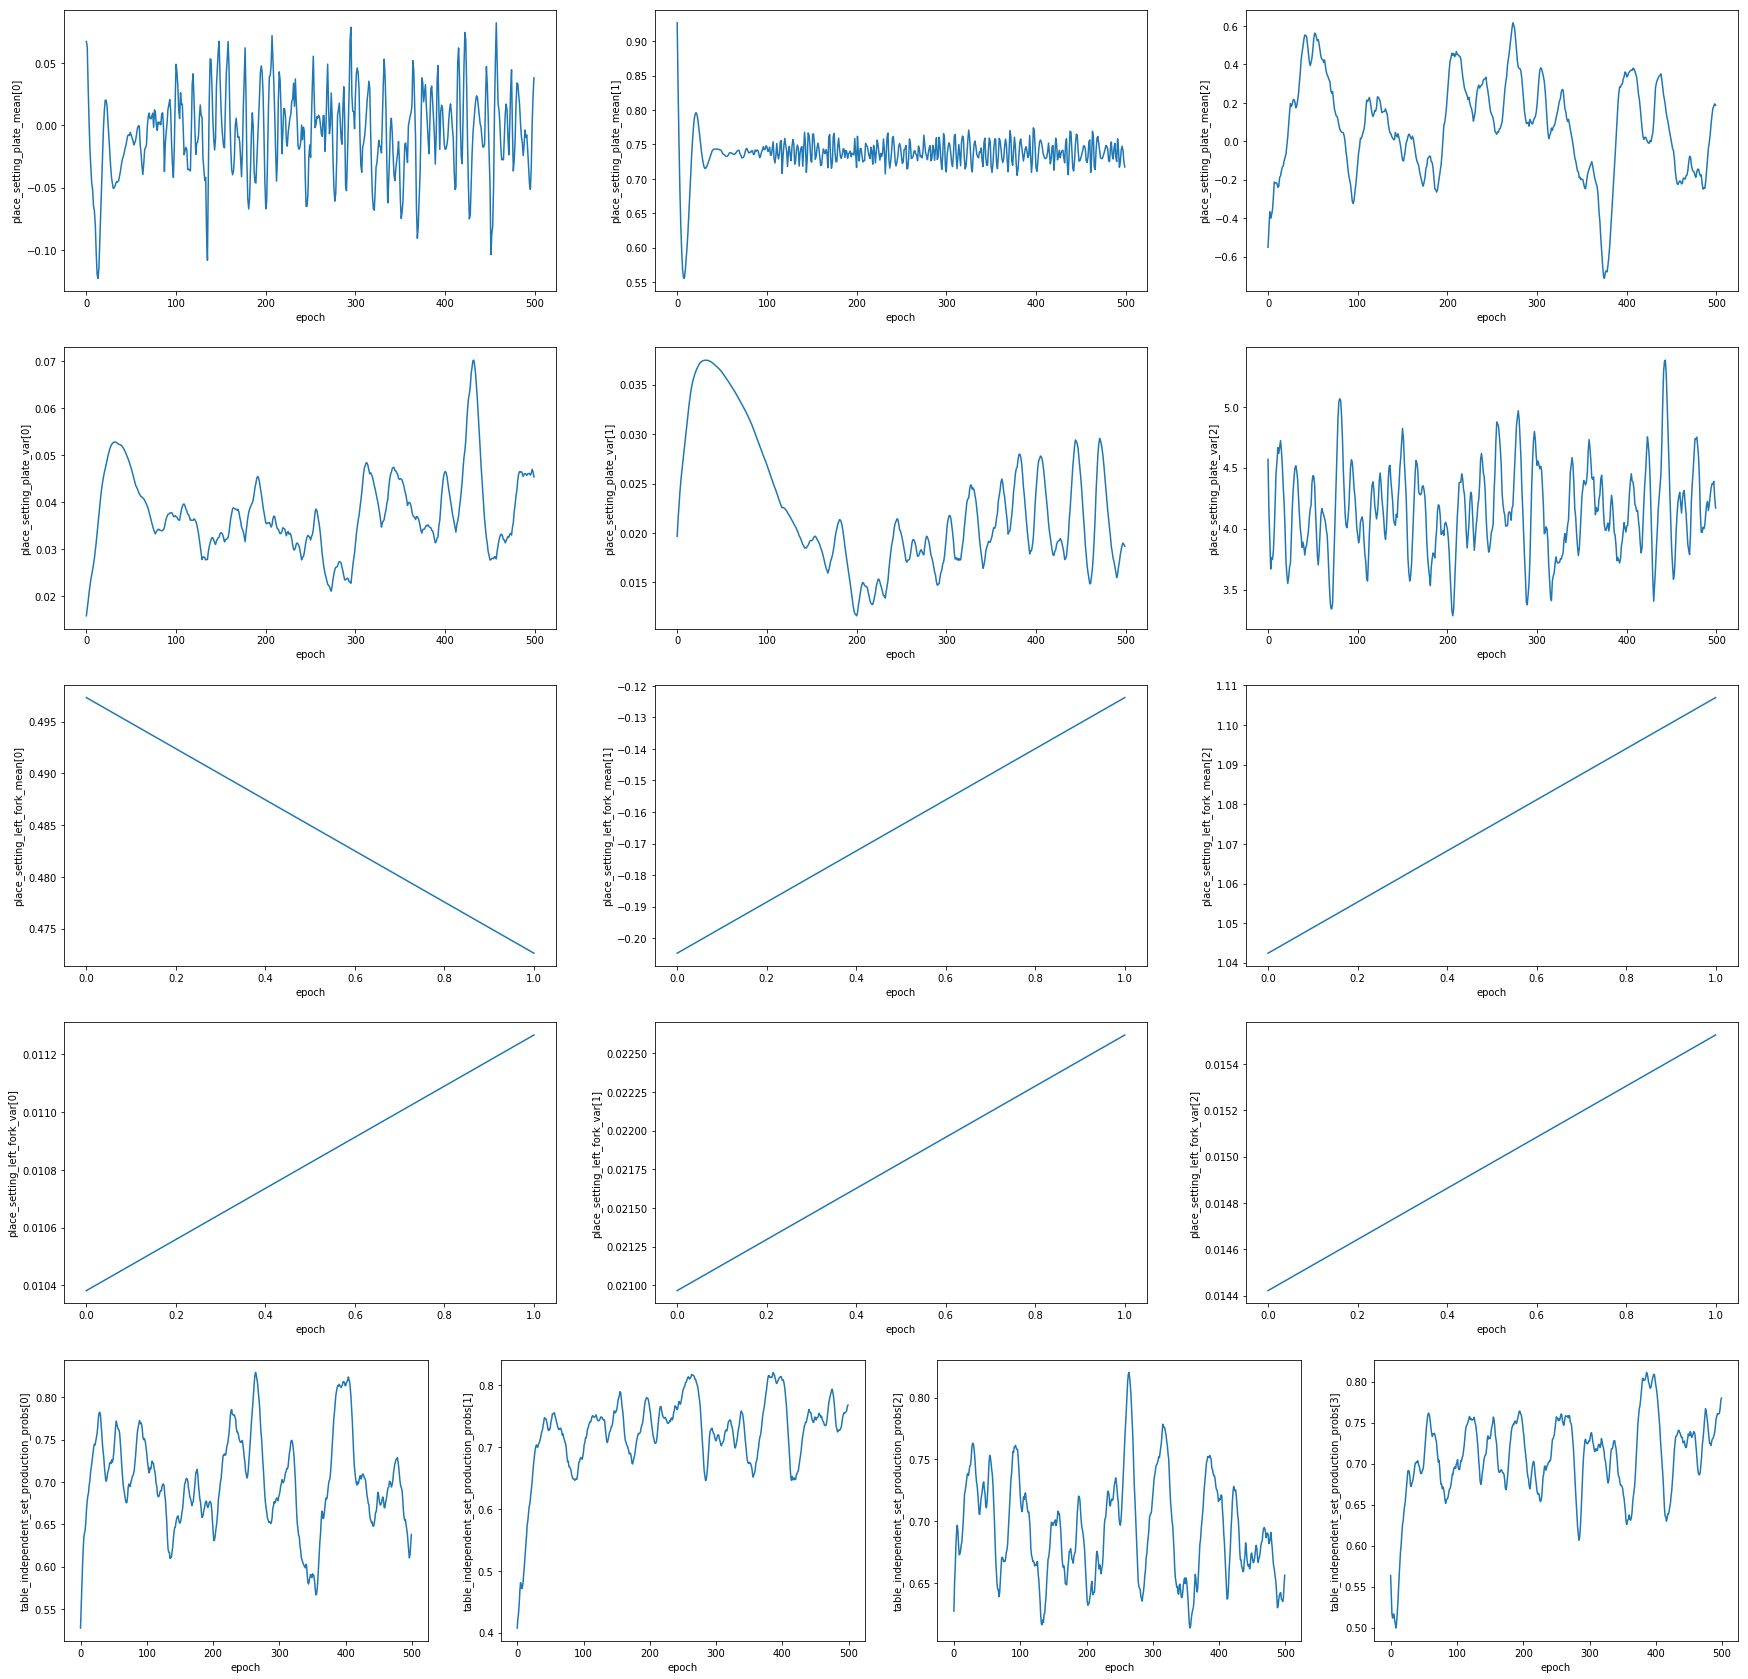

In [16]:
scores_over_time_adjusted = np.array(score_history)
min_score = np.min(scores_over_time_adjusted)
#scores_over_time_adjusted = np.log(scores_over_time_adjusted - min_score + 1.)
plt.plot(score_history)
plt.title("Score history (initial %f, min %f)" % (score_history[0], min_score))
plt.ylabel("-ll")
plt.xlabel("Epoch")
plt.ylim(min_score - 10., min_score + 100.)
print(pyro.get_param_store().get_all_param_names())
names_of_interest = ["place_setting_plate_mean", "place_setting_plate_var", 
                     "place_setting_left_fork_mean", "place_setting_left_fork_var",
                     #"place_setting_production_weights",
                     "table_independent_set_production_probs"]
plt.figure().set_size_inches(30, 30)
for i, name in enumerate(names_of_interest):
    val_epochs = [k for k, d in enumerate(param_val_history) if name in d.keys()]
    vals_across_time = np.vstack([d[name] for d in param_val_history if name in d.keys()]).T
    print(vals_across_time.shape)
    num_vals = vals_across_time.shape[0]
    for j in range(num_vals):
        plt.subplot(len(names_of_interest), num_vals, i*num_vals + j + 1)
        plt.plot(val_epochs, vals_across_time[j, :])
        plt.ylabel(name + "[%d]" % j)
        plt.xlabel("epoch")
#plt.tight_layout()

{'obj_0002': {'img_path': 'table_setting_assets/fork.png', 'color': None, 'pose': [0.7377588674832664, 0.4326563308138033, 1.5598170549509103], 'params': [0.02, 0.14], 'class': 'fork', 'params_names': ['width', 'height']}, 'obj_0003': {'img_path': 'table_setting_assets/cup_water.png', 'color': None, 'pose': [0.653811176209248, 0.6236281248799683, 5.233695347425834], 'params': [0.05], 'class': 'cup', 'params_names': ['radius']}, 'obj_0000': {'img_path': 'table_setting_assets/plate_red.png', 'color': None, 'pose': [0.24317150958069278, 0.5337107842795575, -0.787776272855208], 'params': [0.2], 'class': 'plate', 'params_names': ['radius']}, 'obj_0001': {'img_path': 'table_setting_assets/fork.png', 'color': None, 'pose': [0.38897539646486134, 0.24555375980852698, 6.151838124338867], 'params': [0.02, 0.14], 'class': 'fork', 'params_names': ['width', 'height']}, 'obj_0006': {'img_path': 'table_setting_assets/cup_water.png', 'color': None, 'pose': [0.6563204773076257, 0.3458228690285317, 7.109

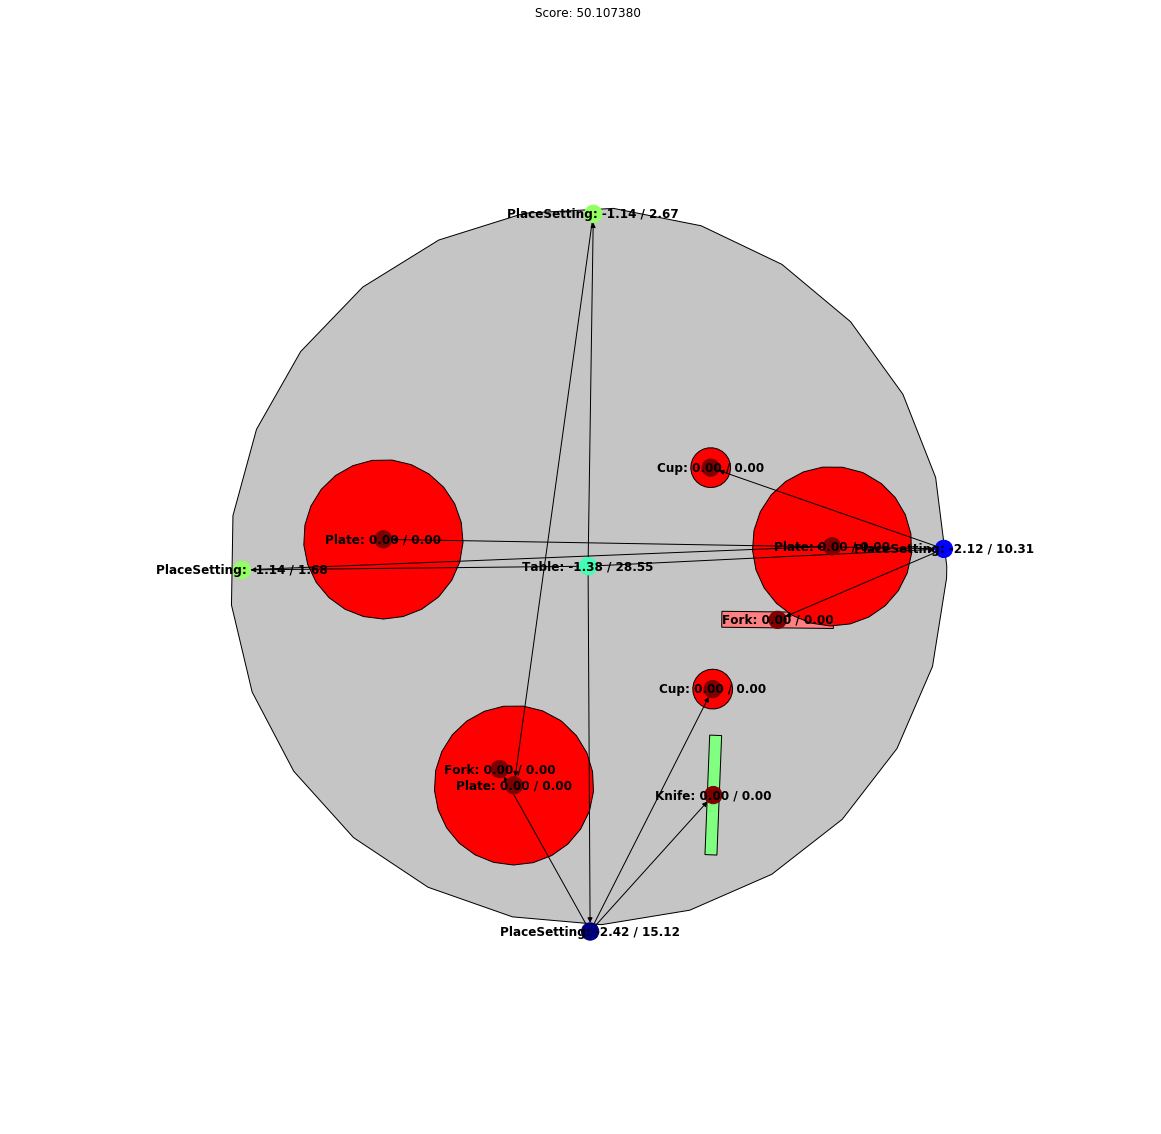

In [25]:
# Generate a ground truth test environment
plt.figure().set_size_inches(20, 20)
trace = poutine.trace(generate_unconditioned_parse_tree).get_trace()
parse_tree = trace.nodes["_RETURN"]["value"]        
score = trace.log_prob_sum()
yaml_env = convert_tree_to_yaml_env(parse_tree)
print(yaml_env)
DrawYamlEnvironmentPlanar(yaml_env, base_environment_type="table_setting", ax=plt.gca())
draw_parse_tree(parse_tree, label_name=True, label_score=True)

In [ ]:
# Generate a bunch of envs + their parse trees
generated_envs_and_trees = []
for k in range(100):
    parse_tree = generate_unconditioned_parse_tree()
    generated_envs_and_trees.append((
        convert_tree_to_yaml_env(parse_tree),
        parse_tree))

In [ ]:
# Instead train on environments in which I have perfect parse trees
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import yaml

# setup the optimizer
adam_params = {"lr": 0.01, "betas": (0.5, 0.5)}
optimizer = Adam(adam_params)
    
pyro.param("place_setting_left_fork_mean").data[0] = 0.0
# do gradient steps
print_param_store()
for step in range(100):
    # Pick a few random environment and parse them
    losses = []
    active_param_names = set()
    random.shuffle(generated_envs_and_trees)
    for env, best_observed_tree in generated_envs_and_trees[:5]:
        best_score, _ = score_tree(best_observed_tree)
        losses.append(-1. * best_score)
        active_param_names = set().union(active_param_names,
            *[node.get_param_names() for node in best_observed_tree.nodes])
    loss = torch.stack(losses).mean()
    #active_param_names = ["place_setting_left_fork_mean"]
    params = set(pyro.get_param_store()._params[name] for name in active_param_names)
    pyro.infer.util.zero_grads(params)
    loss.backward(retain_graph=True)
    #print("Val: ", pyro.param("place_setting_left_fork_mean").detach().cpu().numpy())
    #print("Grad: ", pyro.get_param_store()._params["place_setting_left_fork_mean"].grad)
    #for param in params:
    #   param.data + param.grad*100
    optimizer(params)
    # zero gradients
    pyro.infer.util.zero_grads(params)
    loss = pyro.infer.util.torch_item(loss)
    #loss = svi.step(observed_tree)
    print("Loss: ", loss)
    #print("Place setting plate mean: ", pyro.param("place_setting_plate_mean"))
    #print("Place setting plate var: ", pyro.param("place_setting_plate_var"))
print("Final loss: ", loss)
print_param_store()

In [ ]:
pyro.get_param_store()._params["place_setting_left_fork_var"]

In [ ]:
from matplotlib.patches import Ellipse

# Get offsets of each object class from each place setting
offsets_by_class = {}
scores_by_class = {}
gt_by_class = {}
for observed_env, observed_tree in generated_envs_and_trees:
    score, _ = score_tree(observed_tree)
    for node in observed_tree.nodes:
        if isinstance(node, PlaceSetting.ObjectProductionRule):
            child_class = node.object_name
            if child_class not in offsets_by_class.keys():
                offsets_by_class[child_class] = []
                gt_by_class[child_class] = node.offset_dist
                scores_by_class[child_class] = []
            parent = get_node_parent_or_none(observed_tree, node)
            assert(parent)
            child = list(observed_tree.successors(node))[0]
            offsets_by_class[child_class].append(
                node._recover_rel_pose_from_abs_pose(parent, child.pose).detach().numpy().copy())
            scores_by_class[child_class].append(score.item())
                                                     
plt.figure()
n_classes = len(offsets_by_class.keys())
for k, class_name in enumerate(offsets_by_class.keys()):
    plt.subplot(1, n_classes, k+1)
    plt.title(class_name)
    pts = np.vstack(offsets_by_class[class_name]).T
    plt.scatter(pts[0, :], pts[1, :], c=scores_by_class[class_name], alpha=0.25)
    
    gt_mean = gt_by_class[class_name].mean.detach().numpy().copy()
    gt_std = np.sqrt(gt_by_class[class_name].variance.detach().numpy().copy())
    ell = Ellipse(xy=gt_mean[:2],
                  width=gt_std[0]*3, height=gt_std[1]*3)
    ell.set_color('red')
    ell.set_facecolor('none')
    plt.gca().add_artist(ell)
    plt.xlim(gt_mean[0]-0.2, gt_mean[0]+0.2)
    plt.ylim(gt_mean[1]-0.2, gt_mean[1]+0.2)
    

plt.tight_layout()